In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [2]:
# 1. Load and Visualize the Data
data = pd.read_excel("Gold_price_gbp.xlsx",index_col="Date", parse_dates=True)


In [3]:
# Display the first few rows of the dataframe
print(data.head())

               GBP
Date              
1978-12-29  110.70
1979-01-01  110.70
1979-01-02  111.45
1979-01-03  107.98
1979-01-04  110.66


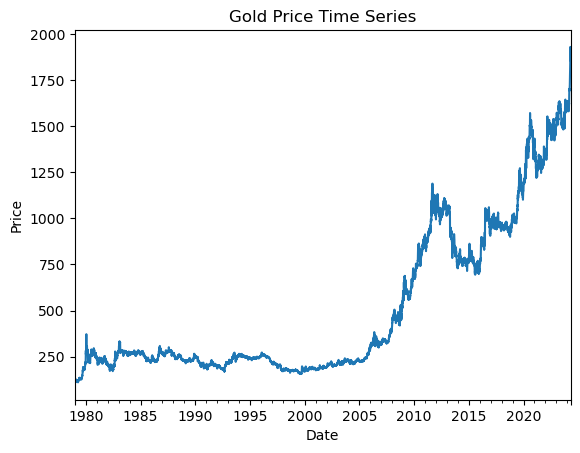

In [4]:
# Visualize the data
data['GBP'].plot(title='Gold Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [5]:
# 2. Prepare the Data
# Create lagged features
# Define the new lag length
#new_lag_length = 200  # Change this to the desired lag length

# Create lagged features
#for i in range(1, new_lag_length + 1):  # Modify the range to include the desired number of lags
#    data[f'value_lag_{i}'] = data['GBP'].shift(i)



data['Lag1'] = data['GBP'].shift(1)
data['Lag2'] = data['GBP'].shift(2)
data['Lag3'] = data['GBP'].shift(3)

# Drop missing values caused by the lag
data.dropna(inplace=True)

print(data)

                GBP     Lag1     Lag2     Lag3
Date                                          
1979-01-03   107.98   111.45   110.70   110.70
1979-01-04   110.66   107.98   111.45   110.70
1979-01-05   111.63   110.66   107.98   111.45
1979-01-08   110.15   111.63   110.66   107.98
1979-01-09   110.95   110.15   111.63   110.66
...             ...      ...      ...      ...
2024-04-22  1891.11  1920.66  1913.97  1923.20
2024-04-23  1870.99  1891.11  1920.66  1913.97
2024-04-24  1864.25  1870.99  1891.11  1920.66
2024-04-25  1852.74  1864.25  1870.99  1891.11
2024-04-26  1876.28  1852.74  1864.25  1870.99

[11823 rows x 4 columns]


In [6]:
# Define features and target variable
X = data[['Lag1', 'Lag2', 'Lag3']]
y = data['GBP']

In [7]:
# 3. Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=False)

In [8]:
# 4. Fit the XGBoost Model
model = xgb.XGBRegressor(objective='count:poisson',base_score=0.5, tree_method='auto', early_stopping_rounds=100, learning_rate = 0.5 , max_depth = 7, n_estimator = 50)
#model = xgb.XGBRegressor(n_estimators = 3000 , early_stopping = 15 , learning_rate = 0.001)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

C:\Users\Nithya\anaconda3\envs\tf\lib\site-packages\xgboost\core.py:160: UserWarning: [21:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=50, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# 5. Make Predictions
y_pred = model.predict(X_test)

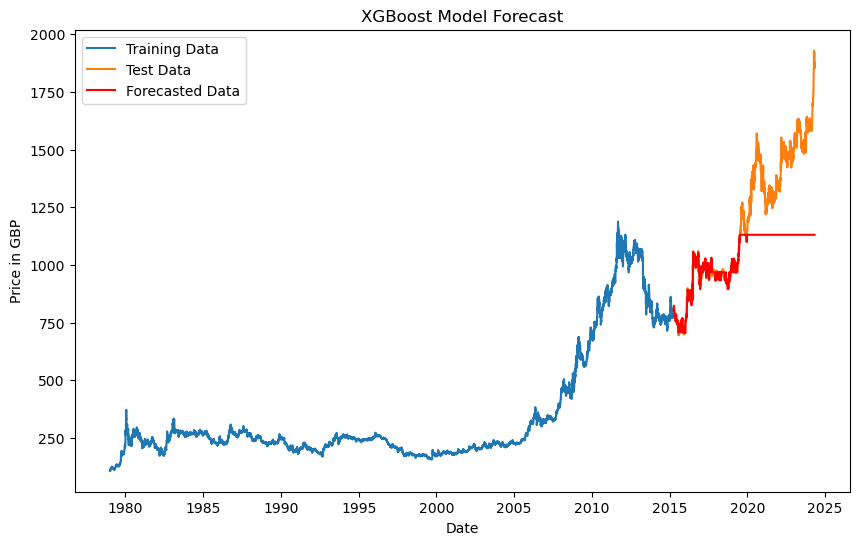

In [10]:
# 6. Evaluate the Model
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(X_train.index, y_train, label='Training Data')
plt.plot(X_test.index, y_test, label='Test Data')
plt.plot(X_test.index, y_pred, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Price in GBP')
plt.title('XGBoost Model Forecast')
plt.legend()
plt.show()

In [11]:
test=y_test.values
train=y_train
forecast=y_pred
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
# Calculate evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test[1:] - forecast[1:]) / test[1:])) * 100
smape = np.mean(2.0 * np.abs(test[1:] - forecast[1:]) / (np.abs(test[1:]) + np.abs(forecast[1:]))) * 100
nrmse = rmse / (test.max() - test.min())
nmd = np.mean(test[1:] - forecast[1:]) / (test.max() - test.min())

mean_price=test.mean()
tss = ((test - mean_price) ** 2).sum()
rss=((test-forecast)**2).sum()
r_squared=1-(rss/tss)
# Mean Absolute Scaled Error (MASE)
# MASE requires a naive forecast (e.g., lagged by one period)
naive_forecast = train.shift(1)
naive_mae = mean_absolute_error(train[1:], naive_forecast[1:])
mase = mae / naive_mae

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%')
print(f'Mean Absolute Scaled Error (MASE): {mase:.2f}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse:.2f}')
print(f'Normalized Mean Deviation (NMD): {nmd:.2f}')
print(f'R-squared: {r_squared:.4f}')

Mean Absolute Error (MAE): 157.16
Mean Squared Error (MSE): 56029.11
Root Mean Squared Error (RMSE): 236.70
Mean Absolute Percentage Error (MAPE): 10.76%
Symmetric Mean Absolute Percentage Error (sMAPE): 12.13%
Mean Absolute Scaled Error (MASE): 54.92
Normalized Root Mean Squared Error (NRMSE): 0.19
Normalized Mean Deviation (NMD): 0.12
R-squared: 0.2827
